In [526]:
from BorderModel import IncrementalModel
from BorderQuery import select_features_simple, select_mungedata_simple
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.grid_search import GridSearchCV
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score

In [418]:
df_train = select_mungedata_simple(2, 1, '2011-1-1', '2015-1-1')

In [419]:
X_test = select_features_simple('2015-1-1', '2015-12-1')

In [420]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=16, bootstrap=True, oob_score=True)
grid = GridSearchCV(model, {})

In [424]:
from BorderModel import IncrementalModel
im = IncrementalModel(df_train, grid)

In [454]:
from BorderModel import IncrementalModel
yhat = im.predict(X_test)

2015-01-01
2015-01-02
2015-01-03
2015-01-04
2015-01-05
2015-01-06
2015-01-07
2015-01-08
2015-01-09
2015-01-10
2015-01-11
2015-01-12
2015-01-13
2015-01-14
2015-01-15
2015-01-16
2015-01-17
2015-01-18
2015-01-19
2015-01-20
2015-01-21
2015-01-22
2015-01-23
2015-01-24
2015-01-25
2015-01-26
2015-01-27
2015-01-28
2015-01-29
2015-01-30
2015-01-31
2015-02-01
2015-02-02
2015-02-03
2015-02-04
2015-02-05
2015-02-06
2015-02-07
2015-02-08
2015-02-09
2015-02-10
2015-02-11
2015-02-12
2015-02-13
2015-02-14
2015-02-15
2015-02-16
2015-02-17
2015-02-18
2015-02-19
2015-02-20
2015-02-21
2015-02-22
2015-02-23
2015-02-24
2015-02-25
2015-02-26
2015-02-27
2015-02-28
2015-03-01
2015-03-02
2015-03-03
2015-03-04
2015-03-05
2015-03-06
2015-03-07
2015-03-08
2015-03-09
2015-03-10
2015-03-11
2015-03-12
2015-03-13
2015-03-14
2015-03-15
2015-03-16
2015-03-17
2015-03-18
2015-03-19
2015-03-20
2015-03-21
2015-03-22
2015-03-23
2015-03-24
2015-03-25
2015-03-26
2015-03-27
2015-03-28
2015-03-29
2015-03-30
2015-03-31
2015-04-01

## Compare against actuals in 2015

In [490]:
actuals = select_mungedata_simple(2, 1, '2015-1-1', '2015-12-1')
actuals = actuals.set_index('date')
actuals = actuals[(actuals.index.minute == 0) | (actuals.index.minute==30)].waittime

In [468]:
from BorderQuery import select_predictions
baseline = select_predictions(2, 'b2014', 1, '2015-1-1', '2015-12-1')

baseline = baseline[(baseline.index.minute == 0) | (baseline.index.minute==30)]

In [547]:
baseline1 = baseline.loc[actuals.index]

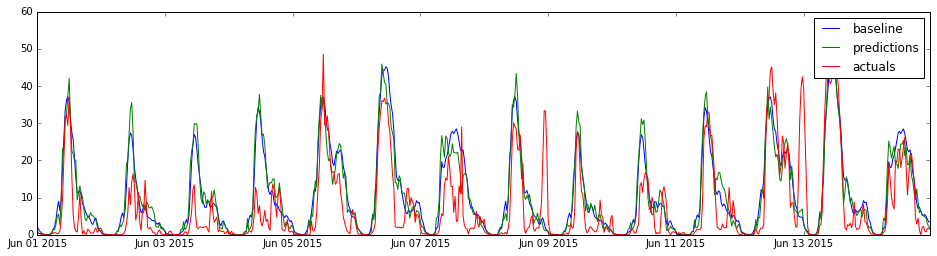

In [548]:
start = dt.date(2015, 6, 1)
end = dt.date(2015, 6, 15)

plt.figure(figsize=(16,4))
plt.plot(baseline[(baseline.index.date>=start) & (baseline.index.date<end)], label='baseline')
plt.plot(yhat[(yhat.index.date>=start) & (yhat.index.date<end)], label='predictions')
plt.plot(actuals[(actuals.index.date>=start) & (actuals.index.date<end)], label='actuals')
# plt.xlim([0,1000])
plt.legend();

In [518]:
yhat1 = yhat[actuals.index]

In [500]:
yhat[actuals.index.values].head()

date
2015-01-01 00:00:00    0.762914
2015-01-01 00:30:00    1.945724
2015-01-01 01:00:00    2.264253
2015-01-01 01:30:00    1.343402
2015-01-01 02:00:00    1.210180
dtype: float64

In [550]:
print r2_score(actuals, baseline1)
print r2_score(actuals, yhat1)

0.147222831424
-0.0328163534288


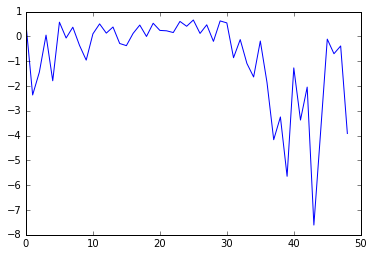

In [524]:
r2_byweek = []
for week in range(1, 50):
    r2_byweek.append(r2_score(actuals[actuals.index.week==week], yhat1[yhat1.index.week==week]))
    
plt.plot(r2_byweek);

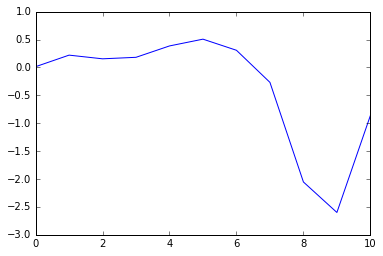

In [525]:
r2_bymonth = []
for month in range(1, 12):
    r2_bymonth.append(r2_score(actuals[actuals.index.month==month], yhat1[yhat1.index.month==month]))
    
plt.plot(r2_bymonth);

In [537]:
print sorted(zip(im.X.columns, grid.best_estimator_.feature_importances_), key=lambda x: x[1])[::-1]

[('minofday', 0.56826360203785142), ('dayofweek', 0.1000209373716259), ('avg_roll_7', 0.065863387802658671), ('avg_roll_14', 0.047653051312855098), ('week', 0.041514107058660439), ('avg_roll_21', 0.041309976681715592), ('avg_roll_366', 0.037849198733552532), ('avg_roll_28', 0.036007612710165046), ('month', 0.03557313836653616), ('year', 0.025944987924379138)]


### R2 is poor with only date features and rolling_means
## Add lag averages

In [580]:
from BorderModel import IncrementalModel
model2 = ExtraTreesRegressor(n_jobs=-1, n_estimators=16, bootstrap=True, oob_score=True)
grid2 = GridSearchCV(model2, {})
im2 = IncrementalModel(df_train, grid2)

In [594]:
from BorderModel import IncrementalModel
yhat2 = im2.predict(X_test)

yhat2 = yhat2[actuals.index]

In [595]:
print r2_score(actuals, baseline1)
print r2_score(actuals, yhat2)

0.147222831424
-0.126750372893


In [596]:
print sorted(zip(im2.X.columns, grid2.best_estimator_.feature_importances_), key=lambda x: x[1])[::-1]

[('minofday', 0.56199531786391177), ('dayofweek', 0.07658738354937436), ('avg_roll_7', 0.038003822810807254), ('avg_lag_6', 0.035065178122831935), ('avg_lag_1', 0.028594340356654712), ('week', 0.024806321625571795), ('month', 0.023718264314319764), ('avg_lag_7', 0.023118193813970282), ('avg_roll_14', 0.023069890704069361), ('avg_lag_5', 0.022847801492528942), ('avg_lag_2', 0.022742269714701335), ('avg_lag_3', 0.022325295629648093), ('avg_roll_366', 0.021273134650144417), ('avg_lag_4', 0.020504106256877132), ('avg_roll_21', 0.019585663449541133), ('avg_roll_28', 0.018259720879969948), ('year', 0.017503294765077702)]


In [597]:
im2.X.head()

,year,month,week,dayofweek,minofday,avg_roll_7,avg_roll_14,avg_roll_21,avg_roll_28,avg_roll_366,avg_lag_1,avg_lag_2,avg_lag_3,avg_lag_4,avg_lag_5,avg_lag_6,avg_lag_7
date,,,,,,,,,,,,,,,,,
2011-11-30 00:00:00,2011,11,48,2,0,6.717844,7.01638,9.294367,9.329579,10.55234,11.185784,6.206193,9.777328,2.184863,6.28092,7.259555,4.836575
2011-11-30 00:30:00,2011,11,48,2,30,6.717844,7.01638,9.294367,9.329579,10.55234,11.185784,6.206193,9.777328,2.184863,6.28092,7.259555,4.836575
2011-11-30 01:00:00,2011,11,48,2,60,6.717844,7.01638,9.294367,9.329579,10.55234,11.185784,6.206193,9.777328,2.184863,6.28092,7.259555,4.836575
2011-11-30 01:30:00,2011,11,48,2,90,6.717844,7.01638,9.294367,9.329579,10.55234,11.185784,6.206193,9.777328,2.184863,6.28092,7.259555,4.836575
2011-11-30 02:00:00,2011,11,48,2,120,6.717844,7.01638,9.294367,9.329579,10.55234,11.185784,6.206193,9.777328,2.184863,6.28092,7.259555,4.836575


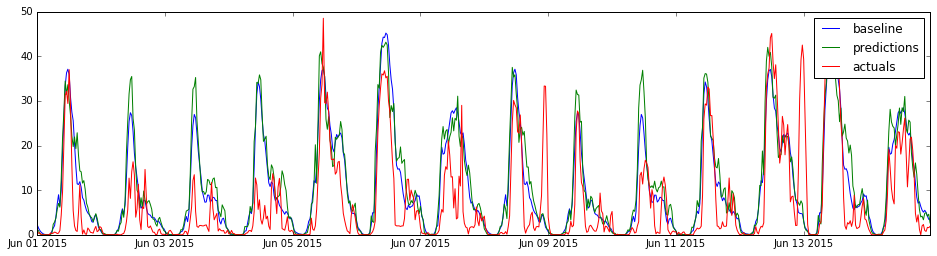

In [600]:
start = dt.date(2015, 6, 1)
end = dt.date(2015, 6, 15)

plt.figure(figsize=(16,4))
plt.plot(baseline[(baseline.index.date>=start) & (baseline.index.date<end)], label='baseline')
plt.plot(yhat2[(yhat2.index.date>=start) & (yhat2.index.date<end)], label='predictions')
plt.plot(actuals[(actuals.index.date>=start) & (actuals.index.date<end)], label='actuals')
# plt.xlim([0,1000])
plt.legend();

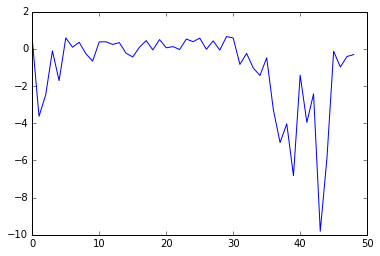

In [601]:
r2_byweek = []
for week in range(1, 50):
    r2_byweek.append(r2_score(actuals[actuals.index.week==week], yhat2[yhat2.index.week==week]))
    
plt.plot(r2_byweek);

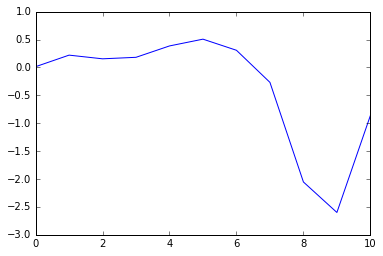

In [599]:
r2_bymonth = []
for month in range(1, 12):
    r2_bymonth.append(r2_score(actuals[actuals.index.month==month], yhat1[yhat2.index.month==month]))
    
plt.plot(r2_bymonth);